In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import sys
sys.path.insert(0, '../')
import new_misc_code as nmc

## **Load raw UMI count data**

In [3]:
# read in count matrices post nuclei and gene quality control
adata = sc.read( "../data/cleaned_count_matrices.h5ad")

In [4]:
# read in adata post clustering and dev-traj assignment
adata2 = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")

In [5]:
adata.obs_names.values

array(['AAACCTGAGAGTCGGT-RL1612_34d_v2', 'AAACCTGAGCCGCCTA-RL1612_34d_v2',
       'AAACCTGAGTCGAGTG-RL1612_34d_v2', ...,
       'TTTGTTGGTAAGGTCG-RL2132_25yr_v3',
       'TTTGTTGGTTCGGCTG-RL2132_25yr_v3',
       'TTTGTTGTCGTCCTCA-RL2132_25yr_v3'], dtype=object)

In [6]:
# add obs and obsm data to matching raw count nuclei
adata = adata[nmc.member_test( adata.obs_names.values, adata2.obs_names.values)]
adata.obs = adata2.obs
adata.obsm = adata2.obsm
adata.uns = adata2.uns
sc.pp.calculate_qc_metrics( adata, inplace=True)

In [7]:
# check if order of BCs match, should sum to 0
(adata.obs_names.values!=adata2.obs_names.values).sum()

0

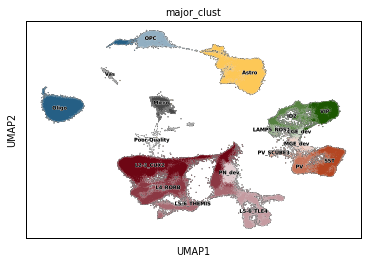

In [8]:
sc.pl.umap( adata, color=['major_clust'], legend_fontsize=5, add_outline=True, legend_loc='on data', size=2, legend_fontoutline=0.5)

## **Clean up features a bit**

In [9]:
# change unknown NaNs in year collected to common date
adata.obs['Collection_year'].fillna( 9999, inplace=True)

In [10]:
# get list of batches
batches = adata.uns['batch_order']

## **Combine by batch and feature of interest**

In [11]:
# we want to pseudo bulk by batch, major dev-traj, and a feature of interest (foi)
# in this case we want to separate out by stage id for each major dev-traj
foi = 'stage_id'
# get list of unique major clusters and define trajs with common developmental clusters
major_clusts = np.unique( adata.obs['major_clust'])
exs = ['L2-3_CUX2','L4_RORB','L5-6_THEMIS'] #,'L5-6_TLE4']
cge = ['VIP','ID2']
mge = ['SST','PV','LAMP5_NOS1','PV_SCUBE3']
major_clusts

array(['Astro', 'CGE_dev', 'ID2', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS',
       'L5-6_TLE4', 'LAMP5_NOS1', 'MGE_dev', 'Micro', 'OPC', 'Oligo',
       'PN_dev', 'PV', 'PV_SCUBE3', 'Poor-Quality', 'SST', 'VIP', 'Vas'],
      dtype=object)

In [12]:
!mkdir ../data/limma-voom

mkdir: cannot create directory ‘../data/limma-voom’: File exists


In [13]:
# set minimum number of nuclei needed to make a bulk data set
min_cells = 10
# loop through major clusters
for dev_itr in major_clusts:
    ### get major dev-traj mask
    # if dev cluster skip
    if( dev_itr in ['PN_dev','CGE_dev','MGE_dev']):
        continue
    # add developing clusters to correct major cluster
    elif( dev_itr in exs):
        dev_mk = np.in1d( adata.obs['major_clust'], [dev_itr,'PN_dev'])
    elif( dev_itr in cge):
        dev_mk = np.in1d( adata.obs['major_clust'], [dev_itr,'CGE_dev'])
    elif( dev_itr in mge):
        dev_mk = np.in1d( adata.obs['major_clust'], [dev_itr,'MGE_dev'])
    else:
        dev_mk = (adata.obs['major_clust']==dev_itr).values
            
    adata_itr = adata[dev_mk]
    #######################################
    # get feature of interest and batches to be bulked
    foi_itr  = adata_itr.obs[foi].unique()
    # add unique label to each bulked stage--batch
    index = [('--').join([x,y]) for x in foi_itr for y in batches]
    # combine ENSG and common gene symbol, will separate once in R
    columns = [ ("--").join((x,y)) for x,y in zip( adata_itr.var['gene_ids'].values, adata_itr.var_names.values)]#
    bulk = pd.DataFrame( index=index, columns=columns)
    ######
    # only want observations that are same across a batch, i.e. observations we can control for
    obs_col_mk = (adata_itr.obs.nunique()<=len(batches)).values
    obs_cols = np.array( adata_itr.obs_keys())[obs_col_mk]
    # drop all dev_traj observations
    obs_cols = [ii for ii in obs_cols if 'traj' not in ii]
    ######
    bulk = pd.DataFrame( index=index, columns=columns)
    obs = pd.DataFrame(  index=index, columns=obs_cols)
    obs['Num_Cells'] = 0
    obs['sub_clust'] = "NaN"
    ######
    for clust_itr in foi_itr:
        clust_mk = adata_itr.obs[foi].values==clust_itr
        clust_adata = adata_itr[clust_mk]
        for batch_itr in batches:
            ind = ('--').join([clust_itr,batch_itr])
            batch_mk = clust_adata.obs['batch'].values==batch_itr
            num_cells = batch_mk.sum()
            if( num_cells<min_cells):
                bulk.drop( ind, axis=0, inplace=True)
                obs.drop(  ind, axis=0, inplace=True)
                continue
            else:
                batch_adata = clust_adata[batch_mk]
                bulk.loc[ind] = batch_adata.X.sum(0).A1
                obs.loc[ind,'Num_Cells'] = num_cells
                obs.loc[ind,foi] = clust_itr
                obs.loc[ind,obs_cols] = batch_adata.obs.iloc[0,obs_col_mk]
    ######
    # check for and replace any /'s
    if( "/" in dev_itr):
        save_mk = [itr for itr, ii in enumerate( dev_itr) if ii=="/"]
        dev_itr = list( dev_itr)
        dev_itr[save_mk[0]] = "-"
        dev_itr = ''.join( dev_itr)
    # transpose because R is weird and save files
    bulk.T.to_csv( f"../data/limma-voom/major-dev-traj_{dev_itr}_pseudo-bulk-cts_min{min_cells}.csv")
    obs.to_csv(  f"../data/limma-voom/major-dev-traj_{dev_itr}_obs-cts_min{min_cells}.csv")

In [14]:
# example output, un-transposed
obs.head()

,batch,RL#,age,chem,concat_id,numerical_age,stage_id,Sex,Race,PMI,...,Library Prep Lot,leiden,mat/dev,cell_type,major_clust,sub_clust,dev_clust,downstream_dev_clusts,combined-leiden,Num_Cells
Neonatal--RL1777_2d_v3,RL1777_2d_v3,RL1777,2d,v3,3,0.00547945,Neonatal,F,White,26,...,4,58,mat,Non-Neu,Vas,Vas_PDGFRB,Vas_PDGFRB,root,58,32
Childhood--RL2125_422d_v3,RL2125_422d_v3,RL2125,422d,v3,19,1.15616,Childhood,F,AA,20,...,8,58,mat,Non-Neu,Vas,Vas_PDGFRB,Vas_PDGFRB,root,58,51
Childhood--RL2105_627d_v3,RL2105_627d_v3,RL2105,627d,v3,9,1.71781,Childhood,M,White,25,...,7,51,mat,Non-Neu,Vas,Vas_TBX18,Vas_TBX18,root,51,22
Childhood--RL2129_3yr_v3,RL2129_3yr_v3,RL2129,3yr,v3,23,3,Childhood,F,White,12,...,8,59,mat,Non-Neu,Vas,Vas_CLDN5,Vas_CLDN5,root,59,75
Childhood--RL2109_4yr_v3,RL2109_4yr_v3,RL2109,4yr,v3,13,4,Childhood,M,White,25,...,7,58,mat,Non-Neu,Vas,Vas_PDGFRB,Vas_PDGFRB,root,58,13


In [15]:
# example output, un-transposed
bulk.head()

,ENSG00000243485--MIR1302-10,ENSG00000238009--RP11-34P13.7,ENSG00000237683--AL627309.1,ENSG00000239906--RP11-34P13.14,ENSG00000228463--AP006222.2,ENSG00000237094--RP4-669L17.10,ENSG00000236743--RP5-857K21.15,ENSG00000231709--RP5-857K21.1,ENSG00000235146--RP5-857K21.2,ENSG00000239664--RP5-857K21.3,...,ENSG00000237375--BX072566.1,ENSG00000215615--AL354822.1,ENSG00000215764--KIR2DL2,ENSG00000217792--KIR3DL2-1,ENSG00000268276--AL590523.1,ENSG00000215700--PNRC2-1,ENSG00000215699--SRSF10-1,ENSG00000215635--AC145205.1,ENSG00000251180--CU459201.1,ENSG00000215616--AC002321.2
Neonatal--RL1777_2d_v3,0,0,0,0,1,2,0,0,0,0,...,0,1,0,0,0,0,3,0,0,0
Childhood--RL2125_422d_v3,0,1,0,0,0,2,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
Childhood--RL2105_627d_v3,0,0,0,0,2,1,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
Childhood--RL2129_3yr_v3,0,0,0,0,1,7,0,0,0,0,...,0,7,0,0,0,0,1,0,0,0
Childhood--RL2109_4yr_v3,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
